In [32]:
import pandas as pd
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

preproc_path = os.path.join(base_dir, 'customer_info_preproc.csv')
customer_info_preproc = pd.read_csv(preproc_path, index_col='customer_id')

preproc_path_outliers = os.path.join(base_dir, 'customer_info_preproc_outliers.csv')
customer_info_preproc_outliers = pd.read_csv(preproc_path_outliers, index_col='customer_id')

combined_data = pd.concat([customer_info_preproc, customer_info_preproc_outliers])

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


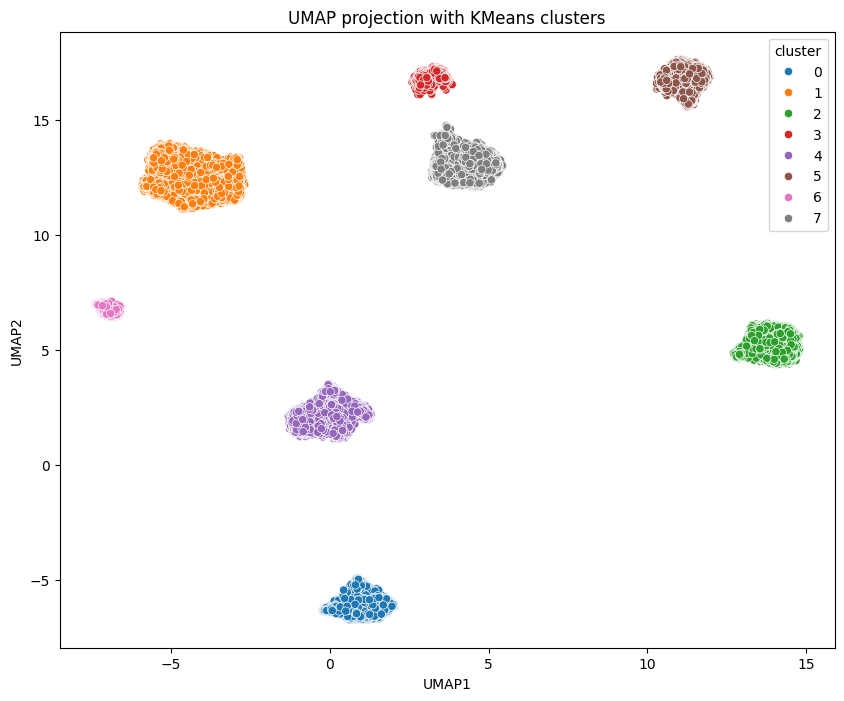

In [31]:
umap_reducer = umap.UMAP(n_neighbors=35, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings_combined = umap_reducer.fit_transform(combined_data)

# split UMAP embeddings back into inliers and outliers
umap_embeddings = umap_embeddings_combined[:len(customer_info_preproc)]
umap_embeddings_outliers = umap_embeddings_combined[len(customer_info_preproc):]

# perform KMeans clustering on inliers
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc.index)
umap_df['cluster'] = kmeans_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='tab10')
plt.title('UMAP projection with KMeans clusters')
plt.show()

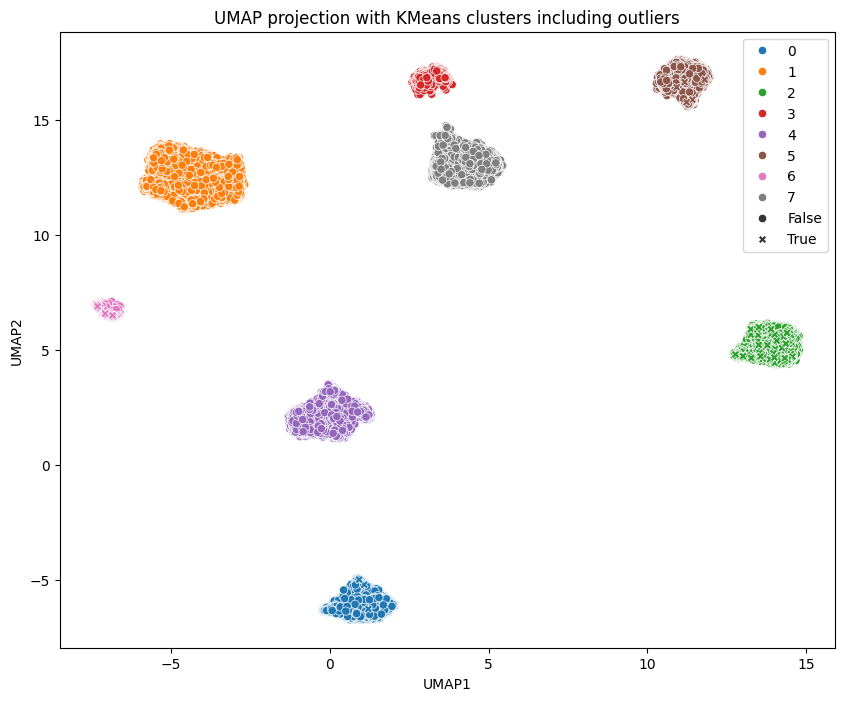

In [33]:
# k-Nearest Neighbors to classify outliers into existing clusters
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(umap_embeddings, kmeans_labels)

# predict clusters for outliers
outlier_clusters = knn.predict(umap_embeddings_outliers)

umap_df_outliers = pd.DataFrame(umap_embeddings_outliers, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc_outliers.index)
umap_df_outliers['cluster'] = outlier_clusters

# combine the inliers and outliers for final visualization
final_umap_df = pd.concat([umap_df, umap_df_outliers])

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=final_umap_df, palette='tab10', style=final_umap_df.index.isin(umap_df_outliers.index))
plt.title('UMAP projection with KMeans clusters including outliers')
plt.legend(loc='best')
plt.show()

In [35]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw/'))
customer_info = pd.read_csv(os.path.join(base_dir, 'customer_info.csv'), index_col='customer_id')
customer_info_clean = clean_customer_data(customer_info)

customer_info_clean_labeled = pd.merge(customer_info_clean, final_umap_df['cluster'], how='left', on='customer_id')

export_clusters(customer_info_clean_labeled, 'cluster')